## Introduction

I would like to analyze the NHANES study and try to use machine learning to predict whether a patient is taking insulin or not. The project will start with data cleaning and exploration. Next we will move into running a RandomForest classifier, K Nearest Neighbors, and an XGBoost model to determine which is most efficient. Once the best model is chosen, I will use a GridSearchCV to optimize that model. 
Because the effect of sugar on blood glucose is well known, I will remove several features dealing with sugar consumption from the dataset to see if there are any further inferences we can make. 
Lastly, because insulin is prescribed to Type 1 as well as Type 2 diabetics, I would like to reiterate through the process to predict whether a patient takes a popular anti-diabetic drug, Glipizide. 

## Import Statements

In [254]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

## Reading in the data and creating dataframes

In [360]:
medications = pd.read_csv('medications.csv', encoding = "ISO-8859-1")

In [361]:
diet = pd.read_csv('diet.csv')

## Cleaning

### First cleaning steps: 
1. From 'medications' I need to know who takes insulin. Encode 1 or 0 based on whether takes insulin or not. 
2. From 'diet' I need to know the top factors that influence whether a person takes insulin or not. 
3. Once both of these datasets are cleaned as such, I need to add them together into one dataframe, clean any unusable values. 
4. Rename columns to names that actually make sense. 

#### Encode whether a patient takes insulin or not

In [5]:
medications.head()

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
0,73557,1,99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,73557,1,INSULIN,d00262,2.0,1460.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,2.0
2,73558,1,GABAPENTIN,d03182,1.0,243.0,G25.81,NaN,NaN,Restless legs syndrome,NaN,NaN,4.0
3,73558,1,INSULIN GLARGINE,d04538,1.0,365.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,4.0
4,73558,1,OLMESARTAN,d04801,1.0,14.0,E11.2,NaN,NaN,Type 2 diabetes mellitus with kidney complicat...,NaN,NaN,4.0


In [105]:
if "INSULIN" in "INSULIN GLARGINE":
    print ("yes")

yes


In [362]:
def boolean_insulin(RXDDRUG):
    if 'INSULIN' in RXDDRUG:
        return 1
    else:
        return 0

In [363]:
medications.isnull().sum()/len(medications)

SEQN        0.000000
RXDUSE      0.000000
RXDDRUG     0.301773
RXDDRGID    0.305932
RXQSEEN     0.305784
RXDDAYS     0.305833
RXDRSC1     0.305635
RXDRSC2     0.964643
RXDRSC3     0.993711
RXDRSD1     0.324898
RXDRSD2     0.964643
RXDRSD3     0.993711
RXDCOUNT    0.301773
dtype: float64

In [364]:
medications['RXDDRUG'].fillna(value = "NULL", inplace = True)

Here I decided to fill the null values with a string "NULL" until I decided how to best handle the large amount of null values in this dataset. 

In [365]:
medications['Insulin'] = medications['RXDDRUG'].map(boolean_insulin)

In [366]:
medications['Insulin'].value_counts(normalize = True)

0    0.986035
1    0.013965
Name: Insulin, dtype: float64

I'm dealing with a very unbalanced dataset here- this means that using accuracy to measure my models is probably not going to be the best way. 

#### Explore Diet, determine top factors for determining Insulin prescriptions

In [124]:
diet.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,16888.327864,12930.890649,1,49.0,2.0,2.0,6.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73558,17932.143865,12684.148869,1,59.0,2.0,2.0,4.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
2,73559,59641.812930,39394.236709,1,49.0,2.0,2.0,18.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73560,142203.069917,125966.366442,1,54.0,2.0,2.0,21.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,59052.357033,39004.892993,1,63.0,2.0,2.0,18.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0


In [125]:
len(diet)

9813

In [367]:
diet.isnull().sum()/len(diet)

SEQN        0.000000
WTDRD1      0.000000
WTDR2D      0.117395
DR1DRSTZ    0.000000
DR1EXMER    0.104963
DRABF       0.117395
DRDINT      0.117395
DR1DBIH     0.112810
DR1DAY      0.104963
DR1LANG     0.103536
DR1MNRSP    0.118211
DR1HELPD    0.120758
DBQ095Z     0.104963
DBD100      0.449811
DRQSPREP    0.104963
DR1STY      0.104963
DR1SKY      0.852441
DRQSDIET    0.104963
DRQSDT1     0.946703
DRQSDT2     0.986650
DRQSDT3     0.987669
DRQSDT4     0.996229
DRQSDT5     1.000000
DRQSDT6     0.999592
DRQSDT7     0.985122
DRQSDT8     0.996535
DRQSDT9     0.993172
DRQSDT10    0.997758
DRQSDT11    0.996841
DRQSDT12    0.999185
              ...   
DRD370GQ    0.980434
DRD370H     0.478141
DRD370HQ    0.990217
DRD370I     0.478141
DRD370IQ    0.988994
DRD370J     0.478141
DRD370JQ    0.998777
DRD370K     0.478141
DRD370KQ    0.985020
DRD370L     0.478141
DRD370LQ    0.996433
DRD370M     0.478141
DRD370MQ    0.819219
DRD370N     0.478141
DRD370NQ    0.978090
DRD370O     0.478141
DRD370OQ    0

In [407]:
diet.fillna(value = 0, inplace = True)

In [408]:
diet.isnull().sum()/len(diet)

WTDRD1      0.0
WTDR2D      0.0
DR1DRSTZ    0.0
DR1EXMER    0.0
DRABF       0.0
DRDINT      0.0
DR1DBIH     0.0
DR1DAY      0.0
DR1LANG     0.0
DR1MNRSP    0.0
DR1HELPD    0.0
DBQ095Z     0.0
DBD100      0.0
DRQSPREP    0.0
DR1STY      0.0
DR1SKY      0.0
DRQSDIET    0.0
DRQSDT1     0.0
DRQSDT2     0.0
DRQSDT3     0.0
DRQSDT4     0.0
DRQSDT5     0.0
DRQSDT6     0.0
DRQSDT7     0.0
DRQSDT8     0.0
DRQSDT9     0.0
DRQSDT10    0.0
DRQSDT11    0.0
DRQSDT12    0.0
DRQSDT91    0.0
           ... 
DRD370GQ    0.0
DRD370H     0.0
DRD370HQ    0.0
DRD370I     0.0
DRD370IQ    0.0
DRD370J     0.0
DRD370JQ    0.0
DRD370K     0.0
DRD370KQ    0.0
DRD370L     0.0
DRD370LQ    0.0
DRD370M     0.0
DRD370MQ    0.0
DRD370N     0.0
DRD370NQ    0.0
DRD370O     0.0
DRD370OQ    0.0
DRD370P     0.0
DRD370PQ    0.0
DRD370Q     0.0
DRD370QQ    0.0
DRD370R     0.0
DRD370RQ    0.0
DRD370S     0.0
DRD370SQ    0.0
DRD370T     0.0
DRD370TQ    0.0
DRD370U     0.0
DRD370UQ    0.0
DRD370V     0.0
Length: 167, dtype: floa

In [217]:
diet.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,16888.327864,12930.9,1,49,2,2,6,2,1,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
1,73558,17932.143865,12684.1,1,59,2,2,4,1,1,...,NULL,2,NULL,2,NULL,2,NULL,2,NULL,2
2,73559,59641.812930,39394.2,1,49,2,2,18,6,1,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
3,73560,142203.069917,125966,1,54,2,2,21,3,1,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
4,73561,59052.357033,39004.9,1,63,2,2,18,1,1,...,NULL,2,NULL,2,NULL,2,NULL,2,NULL,2


In [141]:
medications.head()

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT,Insulin
0,73557,1,99999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
1,73557,1,INSULIN,d00262,2.0,1460.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,2.0,1
2,73558,1,GABAPENTIN,d03182,1.0,243.0,G25.81,NaN,NaN,Restless legs syndrome,NaN,NaN,4.0,0
3,73558,1,INSULIN GLARGINE,d04538,1.0,365.0,E11,NaN,NaN,Type 2 diabetes mellitus,NaN,NaN,4.0,1
4,73558,1,OLMESARTAN,d04801,1.0,14.0,E11.2,NaN,NaN,Type 2 diabetes mellitus with kidney complicat...,NaN,NaN,4.0,0


Now that the data is appropriately cleaned, it's time to create a new dataframe that determines if a patient takes insulin or not, then combine that information with the diet dataframe. 

In [409]:
insulin = pd.DataFrame(medications['SEQN'])

In [410]:
insulin['Insulin'] = medications['Insulin']

In [370]:
insulin.head()

,SEQN,Insulin
0,73557,0
1,73557,1
2,73558,0
3,73558,1
4,73558,0


In [149]:
len(insulin)

20194

In the interest of combining 'Insulin' and 'Diet', I only want one row per SEQN number. If any of the patient's medications are insulin, their SEQN number should return 1. If none of the medications are insulin, their SEQN number should return 0. 

In [411]:
boolean_insulin = pd.DataFrame(insulin.groupby('SEQN')['Insulin'].sum())

In [412]:
boolean_insulin.where(cond = boolean_insulin['Insulin'] == 0, other = 1, inplace = True)

In [413]:
len(diet)

9813

In [414]:
len(boolean_insulin)

10175

#### Combining the DataFrames

In [415]:
diet.set_index('SEQN').head()

KeyError: 'SEQN'

In [393]:
diet.set_index('SEQN', inplace = True)

In [394]:
diet.head()

,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,16888.327864,12930.890649,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73558,17932.143865,12684.148869,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
73559,59641.812930,39394.236709,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73560,142203.069917,125966.366442,1,54.0,2.0,2.0,21.0,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73561,59052.357033,39004.892993,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0


In [416]:
diet_insulin = boolean_insulin.merge(right = diet, how = 'left', left_index = True, right_index = True)

In [417]:
diet_insulin.head()

,Insulin,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73558,1,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
73559,1,59641.812930,39394.236709,1.0,49.0,2.0,2.0,18.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73560,0,142203.069917,125966.366442,1.0,54.0,2.0,2.0,21.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73561,0,59052.357033,39004.892993,1.0,63.0,2.0,2.0,18.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0


In [418]:
boolean_insulin.loc[73557]

Insulin    1
Name: 73557, dtype: int64

In [419]:
diet.loc[73557].head()

WTDRD1      16888.327864
WTDR2D      12930.890649
DR1DRSTZ        1.000000
DR1EXMER       49.000000
DRABF           2.000000
Name: 73557, dtype: float64

In [420]:
len(diet_insulin)

10175

In [422]:
diet_insulin.isnull().sum().head()

Insulin       0
WTDRD1      362
WTDR2D      362
DR1DRSTZ    362
DR1EXMER    362
dtype: int64

For 362 patients, we have information on their prescriptions, but not their dietary information. 
This makes them unusable to us, therefore it will be most appropriate to drop them.  

In [423]:
diet_insulin.dropna(axis = 0, how = 'any', inplace = True)

In [424]:
diet_insulin.isnull().sum().head()

Insulin     0
WTDRD1      0
WTDR2D      0
DR1DRSTZ    0
DR1EXMER    0
dtype: int64

In [425]:
len(diet_insulin)

9813

## Using Random Forest and Feature Importances

In [264]:
y = diet_insulin['Insulin']
X = diet_insulin.drop(['Insulin','SEQN'], axis = 1)

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

In [201]:
# clf = RandomForestClassifier(n_estimators = 100, random_state = 25)
# clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'NULL'

The RandomForest cannot accept null values, or in this case strings. I will deal with my null values- perhaps by converting them to zeros. In the case of this dataset, it is appropriate to replace the nulls with 0.  

In [205]:
diet_insulin.head()

,SEQN,Insulin,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,1,16888.327864,12930.9,1.0,49,2,2,6,2,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
1,73558,1,17932.143865,12684.1,1.0,59,2,2,4,1,...,NULL,2,NULL,2,NULL,2,NULL,2,NULL,2
2,73559,1,59641.812930,39394.2,1.0,49,2,2,18,6,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
3,73560,0,142203.069917,125966,1.0,54,2,2,21,3,...,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL
4,73561,0,59052.357033,39004.9,1.0,63,2,2,18,1,...,NULL,2,NULL,2,NULL,2,NULL,2,NULL,2


In [313]:
diet_insulin['Insulin'].value_counts()

0    9607
1     206
Name: Insulin, dtype: int64

In [231]:
diet_insulin.replace(to_replace = 'NULL', value = 0, inplace = True)

In [232]:
diet_insulin.head()

,SEQN,Insulin,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,1,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73558,1,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
2,73559,1,59641.812930,39394.236709,1.0,49.0,2.0,2.0,18.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73560,0,142203.069917,125966.366442,1.0,54.0,2.0,2.0,21.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73561,0,59052.357033,39004.892993,1.0,63.0,2.0,2.0,18.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0


In [236]:
# clf = RandomForestClassifier(n_estimators = 100, random_state = 25)
# clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [241]:
diet_insulin.isnull().sum().head()

SEQN        0
Insulin     0
WTDRD1      0
WTDR2D      0
DR1DRSTZ    0
dtype: int64

In [296]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 25)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [297]:
clf.score(X_train, y_train)

0.9972619409796166

In [298]:
clf.score(X_test, y_test)

0.9805495523309663

As stated before, when dealing with an unbalanced dataset, the accuracy score is probably not the best measure of how well the model is actually performing. 

In [270]:
importances = clf.feature_importances_.round(2)

In [263]:
X_train.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
4131,77688,11643.350142,8854.038056,1.0,49.0,2.0,2.0,6.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7145,80702,10761.648974,0.000000,1.0,25.0,2.0,1.0,5.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
8091,81648,73649.393632,48646.436178,1.0,87.0,2.0,2.0,21.0,6.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
1304,74861,0.000000,0.000000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,74441,29773.157969,0.000000,1.0,61.0,2.0,1.0,12.0,6.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0


In [279]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

In [271]:
np.argsort(importances)[::-1]

array([ 23,  34,  73,  83,  68,  74,  72,  71,  70,  69,  67,  77,  66,
        65,  64,  63,  62,  61,  76,  78,  58,  79,  80,  81,  82,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  59,  56,  57,  30,
        37,  36,  35,  33,  32,  31,  28,  95,  16,  15,  13,   6,   3,
         1,  38,  39,  40,  41,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  94,   0,  98,  99,  97,  96, 152,  25,
        26,  27, 157,  29, 156, 155, 154, 153, 150, 151, 158, 149, 148,
       147, 146, 145,  42, 144,  24,  21,  22,  10, 164,   2, 163,   4,
         5, 162,   7,   8,   9,  11, 142,  12, 161,  14, 160, 159,  17,
        18,  19,  20, 143, 140, 141, 118, 116, 115, 114,  75, 113, 112,
       111, 110, 109, 108, 107, 165, 106, 105, 104, 103, 102, 101, 100,
       117, 119, 139, 120, 138, 137, 136, 135, 134, 133, 132, 131, 130,
       129, 128,  60, 127, 126, 125, 124, 123, 122, 121, 166], dtype=int64)

In [272]:
importances

array([0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.06, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.01,
       0.01, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [274]:
X_train.columns[23]

'DRQSDT7'

In [280]:
names

['DRQSDT7',
 'DR1TSUGR',
 'DR1TCAFF',
 'DR1TS160',
 'DR1TZINC',
 'DR1TTHEO',
 'DR1TSELE',
 'DR1TPOTA',
 'DR1TSODI',
 'DR1TCOPP',
 'DR1TIRON',
 'DR1TS040',
 'DR1TMAGN',
 'DR1TPHOS',
 'DR1TCALC',
 'DR1TVK',
 'DR1TVD',
 'DR1TVC',
 'DR1TMOIS',
 'DR1TS060',
 'DR1TCHL',
 'DR1TS080',
 'DR1TS100',
 'DR1TS120',
 'DR1TS140',
 'DR1TS180',
 'DR1TM161',
 'DR1TM181',
 'DR1TM201',
 'DR1TM221',
 'DR1TP182',
 'DR1TP183',
 'DR1TP184',
 'DR1TP204',
 'DR1TP205',
 'DR1TVB12',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TNUMF',
 'DR1TSFAT',
 'DR1TTFAT',
 'DR1TFIBE',
 'DR1TCARB',
 'DR1TPROT',
 'DR1TKCAL',
 'DRQSDT12',
 'DR1TP226',
 'DRQSDIET',
 'DR1SKY',
 'DRQSPREP',
 'DR1DBIH',
 'DR1EXMER',
 'WTDR2D',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TP225',
 'WTDRD1',
 'DR1.330Z',
 'DR1BWATZ',
 'DR1.320Z',
 'DR1.300',
 'DRD370O',
 'DRQSDT9',
 'DRQSDT10',
 

Top 3 feature importances:
DRQSDT7 = 	What kind of diet are you on? (Is it a weight loss or low calorie diet: low fat or cholesterol diet; low salt or sodium diet; sugar free or low sugar diet; low fiber diet; high fiber diet; diabetic diet; or another type of diet?)
DR1TSUGR = Total sugars (gm)
DR1TCAFF = Caffeine (mg)

In [483]:
diet_insulin['DRQSDT7'].value_counts()

0.0    9667
7.0     146
Name: DRQSDT7, dtype: int64

According to NHANES documentation, a 7 is used to signify that a patient chose not to respond. The most important feature is based off whether participants chose to respond or not- it is speculation as to whether that negatively impacts their liklihood of being prescribed insulin. 

In the interest of exploration, later I will remove 'cheat' features- things like diet questions and sugar consumption, to see if that yields anything interesting as far as non-sugar indicators of insulin prescriptions. 

In [289]:
plt.style.use('fivethirtyeight')

Text(0, 0.5, 'MGs of Caffeine')

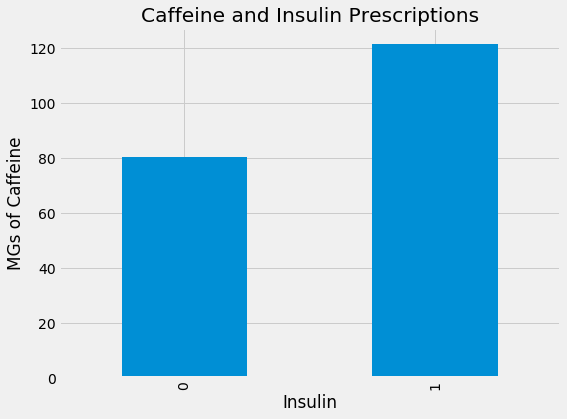

In [290]:
diet_insulin.groupby('Insulin')['DR1TCAFF'].mean().plot(kind = 'bar', figsize = (8, 6))
plt.title("Caffeine and Insulin Prescriptions")
plt.ylabel("MGs of Caffeine")

In [287]:
diet_insulin['DR1TCAFF'].head()

0    203.0
1    240.0
2     45.0
3      0.0
4     24.0
Name: DR1TCAFF, dtype: float64

It is interesting to see caffeine at such a high place in the list. My first thought is that caffeine may be an indicator because of soda, energy drinks and sugary coffees.  

In [292]:
clf.classes_

array([0, 1], dtype=int64)

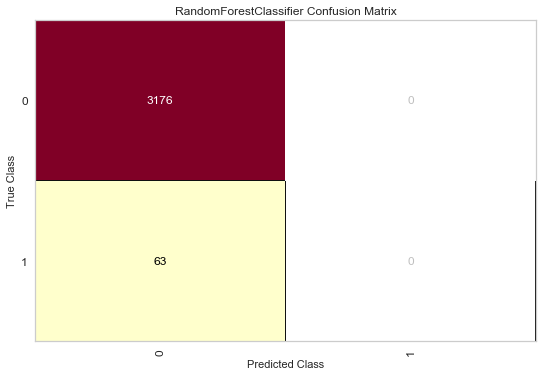

In [299]:
rf_cm = ConfusionMatrix(clf, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
rf_cm.fit(X_train, X_test)
rf_cm.score(X_test, y_test)
rf_cm.show()

The model predicts nobody is on Insulin... which turns out to be 98% true. 
I will make a second attempt using class_weight = balanced to help deal with the problem of unbalanced data. 

In [300]:
clf_balanced = RandomForestClassifier(n_estimators = 10,class_weight = 'balanced', random_state = 25)
clf_balanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False, random_state=25,
            verbose=0, warm_start=False)

In [304]:
clf_balanced.score(X_train, y_train)

0.8948889564952844

In [306]:
clf_balanced.score(X_test, y_test)

0.8826798394566224

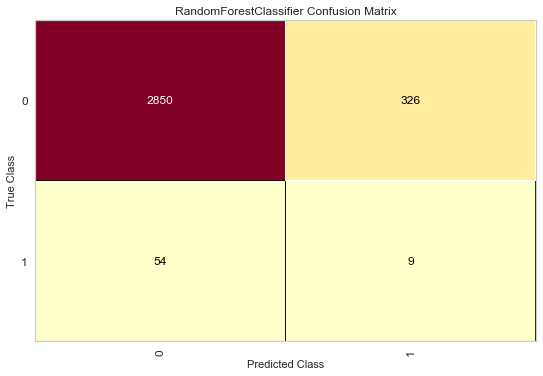

In [308]:
rf_cm_balanced = ConfusionMatrix(clf_balanced, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
rf_cm_balanced.fit(X_train, X_test)
rf_cm_balanced.score(X_test, y_test)
rf_cm_balanced.show()

In [328]:
f1_score(y_test, clf_balanced.predict(X_test))

0.04522613065326633

The model is incorrectly predicting that 362 people are prescribed insulin. It may be worth speaking to their doctor about their diet and changes they can make to prevent future insulin prescriptions.  

### KNN

With a KNN, it is important that I tune the n_neighbors before selecting the best performing model. 

In [315]:
KNN = KNeighborsClassifier()

In [317]:
KNN.fit(X_train, y_train)
KNN.score(X_train, y_train)

0.9780955278369333

In [318]:
KNN.score(X_test, y_test)

0.9790058660080272

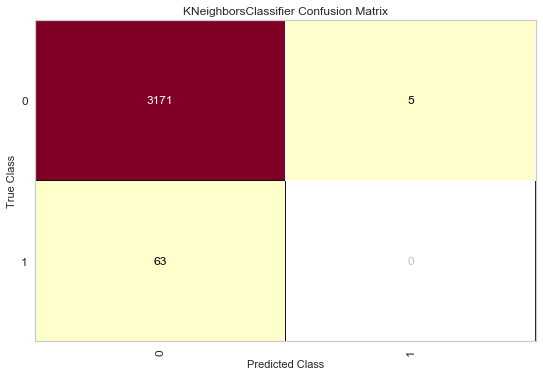

In [319]:
KNN_cm = ConfusionMatrix(KNN, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
KNN_cm.fit(X_train, X_test)
KNN_cm.score(X_test, y_test)
KNN_cm.show()

In [322]:
f1_score(y_test, KNN.predict(X_test))

0.0

In [323]:
KNN_n1 = KNeighborsClassifier(n_neighbors = 1)
KNN_n1.fit(X_train, y_train)
KNN_n1.score(X_train, y_train)

0.9972619409796166

In [324]:
f1_score(y_test, KNN_n1.predict(X_test))

0.0

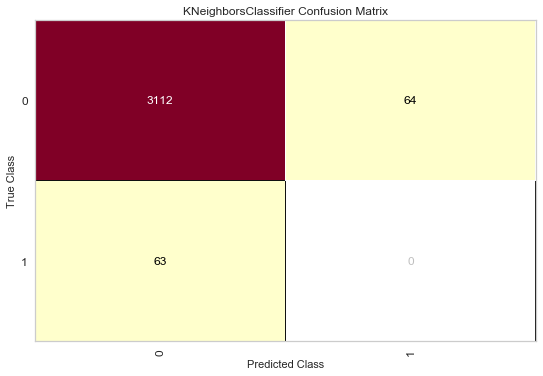

In [325]:
KNN_n1_cm = ConfusionMatrix(KNN_n1, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
KNN_n1_cm.fit(X_train, X_test)
KNN_n1_cm.score(X_test, y_test)
KNN_n1_cm.show()

In [330]:
y_train.value_counts()

0    6431
1     143
Name: Insulin, dtype: int64

In [331]:
y_test.value_counts()

0    3176
1      63
Name: Insulin, dtype: int64

In [332]:
accuracy_scores = []
for i in range(1,30):
    KNN_x = KNeighborsClassifier(n_neighbors = i)
    KNN_x.fit(X_train, y_train)
    accuracy_scores.append(f1_score(y_test, KNN_x.predict(X_test)))
    

1
2
3
4
5
6


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


7
8
9
10


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


11


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


12


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


13


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


14


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


15


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


16


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


17


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


18


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


19


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


20


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


21


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


22


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


23


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


24


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


25


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


26


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


27


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


28


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


29


C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


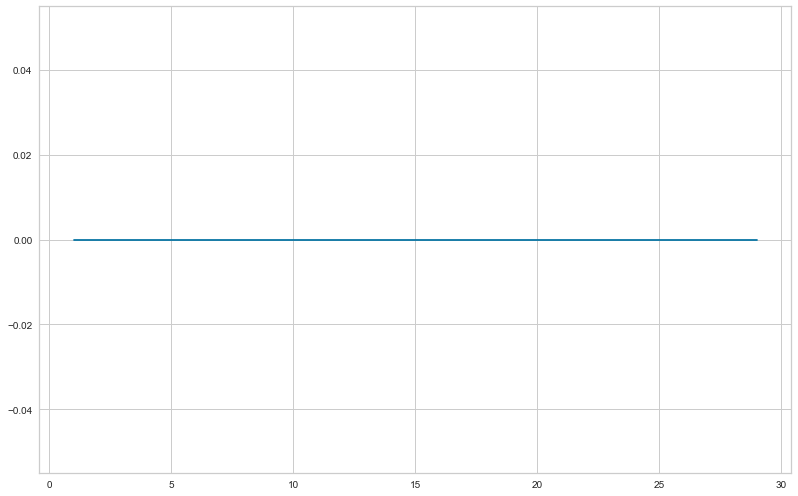

In [333]:
fig = plt.figure(figsize = (12, 8))
plt.plot(range(1,30), accuracy_scores)

KNN is probably not our best model, it isn't dealing with the unbalanced data very well, even after tuning n_neighbors. There is no parameter to balance the dataset. 

### XGBoost

In [337]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
XGB.score(X_train, y_train)

0.9841801034377852

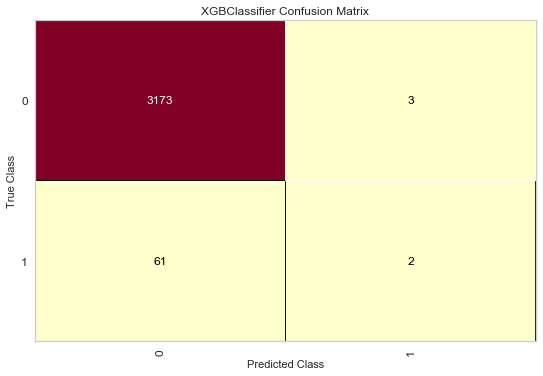

In [338]:
XGB_cm = ConfusionMatrix(XGB, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
XGB_cm.fit(X_train, X_test)
XGB_cm.score(X_test, y_test)
XGB_cm.show()

In [339]:
f1_score(y_test, XGB.predict(X_test))

0.058823529411764705

Using F1 Score as our target for accuracy we see the following results for our models:
Balanced Random Forest Classifier: 0.045
K Nearest Neighbors (Optimized n_estimators): 0.0
XGBoost: 0.059

In terms of unbalanced data, it looks like XGBoost is our most efficient algorithm. 

### Use GridSearch to make it better

In [342]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [1, 5, 10],
    'min_child_weight': [1, 2, 5],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 50, 100],
}

In [345]:
grid_XGB = GridSearchCV(XGB, param_grid, scoring = 'accuracy', cv = None, n_jobs = 1)
grid_XGB.fit(X_train, y_train)

best_parameters = grid_XGB.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_XGB.predict(X_train)
test_preds = grid_XGB.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: ", training_accuracy)
print("Test Accuracy: ", test_accuracy)

grid_XGB_f1 = f1_score(y_test, grid_XGB.predict(X_test))
print("F1 Score: ", grid_XGB_f1)

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 5
min_child_weight: 1
n_estimators: 10
subsample: 0.7
Training Accuracy:  0.9834195314876787
Test Accuracy:  0.9796233405372028
F1 Score:  0.1081081081081081


In [347]:
XGB_f1 = f1_score(y_test, XGB.predict(X_test))

In [348]:
grid_XGB_f1 - XGB_f1

0.049284578696343395

Optimizing several parameters on our best performing model yielded a 4.9% increase in the f1 score, in order to give us the best possible model. 

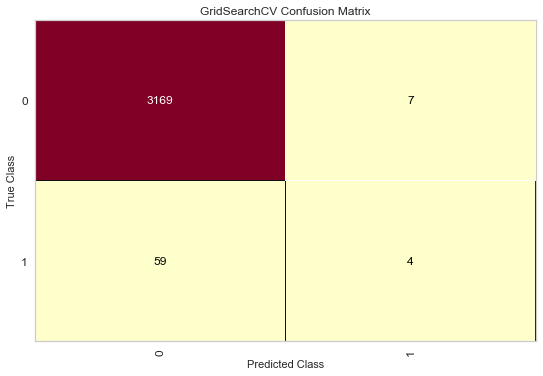

In [356]:
grid_XGB_cm = ConfusionMatrix(grid_XGB, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
grid_XGB_cm.fit(X_train, X_test)
grid_XGB_cm.score(X_test, y_test)
grid_XGB_cm.show()

Our model is incorrectly predicting 7 people to be on insulin. Again, it may be in the best interest of these patients to talk to their doctors and consider dietary changes. 

### Choose best performing model, remove 'cheat' features, just to satisfy curiosity

Columns to drop:
'DR1TSUGR','DRQSDT1','DRQSDT10', 'DRQSDT11', 'DRQSDT12',
'DRQSDT2','DRQSDT3','DRQSDT4','DRQSDT5','DRQSDT6','DRQSDT7',
'DRQSDT8','DRQSDT9','DRQSDT91','DR2TSUGR','DR1ISUGR','DR2ISUGR',
'DS1ISUGR','DSQISUGR','DS2ISUGR','DS1TSUGR','DS2TSUGR','DSQTSUGR'

These features were chosen based on whether they specifically asked if the participant was on a special diet, and regarding the amount of sugar they consumed in a day. The purpose of this section is to determine if there are any links between non-obvious features and insulin prescriptions.  
Several columns were listed in the CDC variable directory that were not actually part of the diet_insulin dataframe. They were omitted from the drop, because there was nothing to drop. 

In [358]:
list(diet_insulin.columns)

['SEQN',
 'Insulin',
 'WTDRD1',
 'WTDR2D',
 'DR1DRSTZ',
 'DR1EXMER',
 'DRABF',
 'DRDINT',
 'DR1DBIH',
 'DR1DAY',
 'DR1LANG',
 'DR1MNRSP',
 'DR1HELPD',
 'DBQ095Z',
 'DBD100',
 'DRQSPREP',
 'DR1STY',
 'DR1SKY',
 'DRQSDIET',
 'DRQSDT1',
 'DRQSDT2',
 'DRQSDT3',
 'DRQSDT4',
 'DRQSDT5',
 'DRQSDT6',
 'DRQSDT7',
 'DRQSDT8',
 'DRQSDT9',
 'DRQSDT10',
 'DRQSDT11',
 'DRQSDT12',
 'DRQSDT91',
 'DR1TNUMF',
 'DR1TKCAL',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TSFAT',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 'DR1TVK',
 'DR1TCALC',
 'DR1TPHOS',
 'DR1TMAGN',
 'DR1TIRON',
 'DR1TZINC',
 'DR1TCOPP',
 'DR1TSODI',
 'DR1TPOTA',
 'DR1TSELE',
 'DR1TCAFF',
 'DR1TTHEO',
 'DR1TALCO',
 'DR1TMOIS',
 'DR1TS040',
 'DR1TS060'

In [435]:
cheat_df = diet_insulin.drop(['DR1TSUGR','DRQSDT1','DRQSDT10', 'DRQSDT11', 'DRQSDT12',
                            'DRQSDT2','DRQSDT3','DRQSDT4','DRQSDT5','DRQSDT6','DRQSDT7',
                            'DRQSDT8','DRQSDT9','DRQSDT91'], axis = 1)

In [436]:
cheat_df.head()

,Insulin,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,16888.327864,12930.890649,1.0,49.0,2.0,2.0,6.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73558,1,17932.143865,12684.148869,1.0,59.0,2.0,2.0,4.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
73559,1,59641.812930,39394.236709,1.0,49.0,2.0,2.0,18.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73560,0,142203.069917,125966.366442,1.0,54.0,2.0,2.0,21.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73561,0,59052.357033,39004.892993,1.0,63.0,2.0,2.0,18.0,1.0,1.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0


In [441]:
cheat_y = cheat_df['Insulin']
cheat_X = cheat_df.drop(['Insulin'], axis = 1)

In [442]:
X_train_cheat, X_test_cheat, y_train_cheat, y_test_cheat = train_test_split(cheat_X, cheat_y, 
                                                                            test_size = 0.33, random_state = 25)

In [445]:
XGB_cheat = XGBClassifier()
XGB_cheat.fit(X_train_cheat, y_train_cheat)
XGB_cheat.score(X_train_cheat, y_train_cheat)

0.979464557347125

In [446]:
XGB_cheat_f1 = f1_score(y_test_cheat, XGB_cheat.predict(X_test_cheat))

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


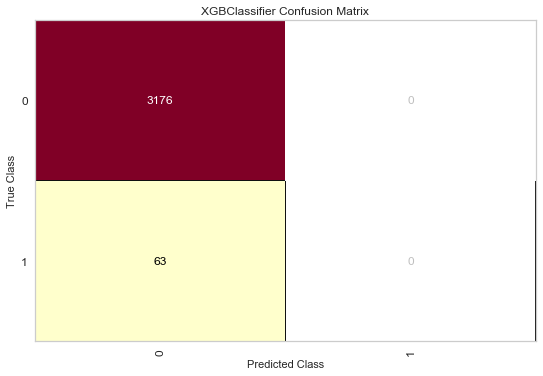

In [447]:
XGB_cheat_cm = ConfusionMatrix(XGB_cheat, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
XGB_cheat_cm.fit(X_train_cheat, X_test_cheat)
XGB_cheat_cm.score(X_test_cheat, y_test_cheat)
XGB_cheat_cm.show()

The model is predicting that nobody takes insulin. While it is 97% accurate, we get an F1 score of 0.0. Next I will try to optimize the model using GridSearchCV, and make further analysis if that yields a better model. 

In [448]:
cheat_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [1, 5, 10],
    'min_child_weight': [1, 2, 5],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 50, 100],
}

In [449]:
grid_XGB_cheat = GridSearchCV(XGB_cheat, cheat_param_grid, scoring = 'accuracy', cv = None, n_jobs = 1)
grid_XGB_cheat.fit(X_train_cheat, y_train_cheat)

best_parameters_cheat = grid_XGB_cheat.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters_cheat.keys()):
    print('%s: %r' % (param_name, best_parameters_cheat[param_name]))

training_preds_cheat = grid_XGB_cheat.predict(X_train_cheat)
test_preds_cheat = grid_XGB_cheat.predict(X_test_cheat)
training_accuracy_cheat = accuracy_score(y_train_cheat, training_preds_cheat)
test_accuracy_cheat = accuracy_score(y_test_cheat, test_preds_cheat)

print("Training Accuracy: ", training_accuracy_cheat)
print("Test Accuracy: ", test_accuracy_cheat)

grid_XGB_f1_cheat = f1_score(y_test_cheat, grid_XGB_cheat.predict(X_test_cheat))
print("F1 Score: ", grid_XGB_f1_cheat)

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 5
min_child_weight: 1
n_estimators: 100
subsample: 0.5
Training Accuracy:  0.9969577121995741
Test Accuracy:  0.9799320778017907
F1 Score:  0.0


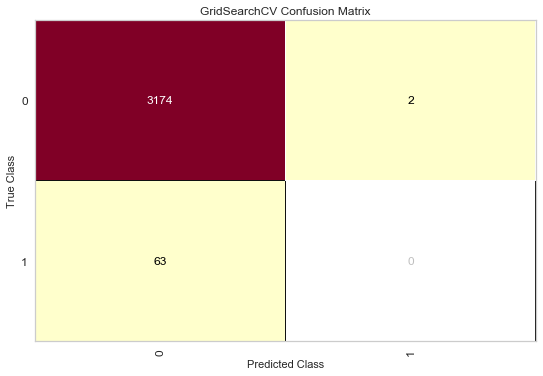

In [468]:
grid_XGB_cheat_cm = ConfusionMatrix(grid_XGB_cheat, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
grid_XGB_cheat_cm.fit(X_train_cheat, y_train_cheat)
grid_XGB_cheat_cm.score(X_test_cheat, y_test_cheat)
grid_XGB_cheat_cm.show()

This still is not a great model- it didn't correctly predict anyone who is actually on insulin. This still can lead to analysis- the features removed were ones dealing with sugar consumption and special diets. These results really underscore how important sugar and diet are to predicting whether somebody takes insulin or not. 

## Further Analysis using Glipizide

Because insulin is used for Type 1 diabetics as well as Type 2, I feel further investigation is warranted into a medication that treats Type 2 diabetes. I chose Glipizide. I will run through the same process of choosing the most efficient model and then using that to draw conclusions. 

In [452]:
def boolean_glipizide(RXDDRUG):
    if 'GLIPIZIDE' in RXDDRUG:
        return 1
    else:
        return 0

In [453]:
medications['Glipizide'] = medications['RXDDRUG'].map(boolean_glipizide)

In [454]:
glip = pd.DataFrame(medications['SEQN'])

In [455]:
glip['Glipizide'] = medications['Glipizide']

In [456]:
glip.head()

,SEQN,Glipizide
0,73557,0
1,73557,0
2,73558,0
3,73558,0
4,73558,0


In [458]:
boolean_glip = pd.DataFrame(glip.groupby('SEQN')['Glipizide'].sum())

In [459]:
boolean_glip.where(cond = boolean_glip['Glipizide'] == 0, other = 1, inplace = True)

In [460]:
diet_glipizide = boolean_glip.merge(right = diet, how = 'left', left_index = True, right_index = True)

In [461]:
diet_glipizide.isnull().sum().head()

Glipizide      0
WTDRD1       362
WTDR2D       362
DR1DRSTZ     362
DR1EXMER     362
dtype: int64

In [462]:
diet_glipizide.dropna(axis = 0, how = 'any', inplace = True)

In [463]:
diet_glipizide.isnull().sum().head()

Glipizide    0
WTDRD1       0
WTDR2D       0
DR1DRSTZ     0
DR1EXMER     0
dtype: int64

In [464]:
y_glip = diet_glipizide['Glipizide']
X_glip = diet_glipizide.drop('Glipizide', axis = 1)

In [465]:
X_train_glip, X_test_glip, y_train_glip, y_test_glip = train_test_split(X_glip, y_glip, test_size = 0.33, random_state = 25)

### Random Forest

In [466]:
clf_balanced_glip = RandomForestClassifier(n_estimators = 10,class_weight = 'balanced', random_state = 25)
clf_balanced_glip.fit(X_train_glip, y_train_glip)
clf_balanced_glip.score(X_train_glip, y_train_glip)

0.9963492546394889

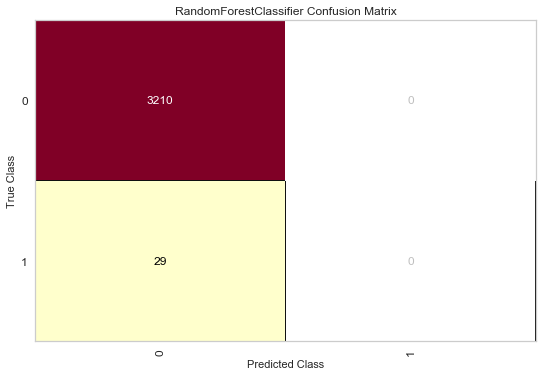

In [467]:
clf_balanced_glip_cm = ConfusionMatrix(clf_balanced_glip, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
clf_balanced_glip_cm.fit(X_train_glip, y_test_glip)
clf_balanced_glip_cm.score(X_test_glip, y_test_glip)
clf_balanced_glip_cm.show()

In [469]:
f1_score(y_test_glip, clf_balanced_glip.predict(X_test_glip))

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

The dataset is EXTREMELY unbalanced- this may carry forward into our next few models. It's going to be very hard to make predictions based on this data. 

### KNN

In [470]:
glip_accuracy_scores = []
for i in range(1,10):
    glip_KNN_x = KNeighborsClassifier(n_neighbors = i)
    glip_KNN_x.fit(X_train_glip, y_train_glip)
    glip_accuracy_scores.append(f1_score(y_test_glip, glip_KNN_x.predict(X_test_glip)))

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classificatio

In [471]:
glip_accuracy_scores

[0.03636363636363637, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

There seems to be an unexpected F1 score. This warrants further investigation. 

In [473]:
glip_KNN_1 = KNeighborsClassifier(n_neighbors = 1)
glip_KNN_1.fit(X_train_glip, y_train_glip)
print(f1_score(y_test_glip, glip_KNN_1.predict(X_test_glip)))

0.03636363636363637


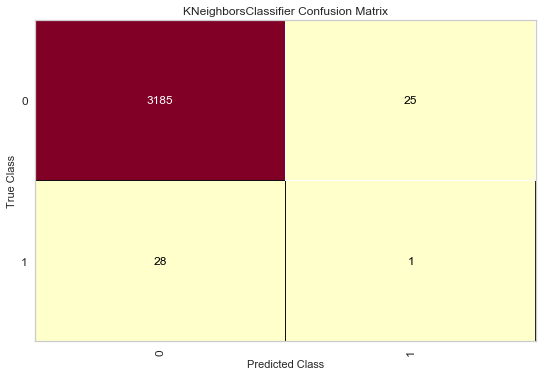

In [474]:
KNN_glip_cm = ConfusionMatrix(glip_KNN_1, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
KNN_glip_cm.fit(X_train_glip, y_test_glip)
KNN_glip_cm.score(X_test_glip, y_test_glip)
KNN_glip_cm.show()

### XGBoost

In [475]:
XGB_glip = XGBClassifier()
XGB_glip.fit(X_train_glip, y_train_glip)
XGB_glip.score(X_train_glip, y_train_glip)

0.9928506236689991

In [476]:
f1_score(y_test_glip, XGB_glip.predict(X_test_glip))

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

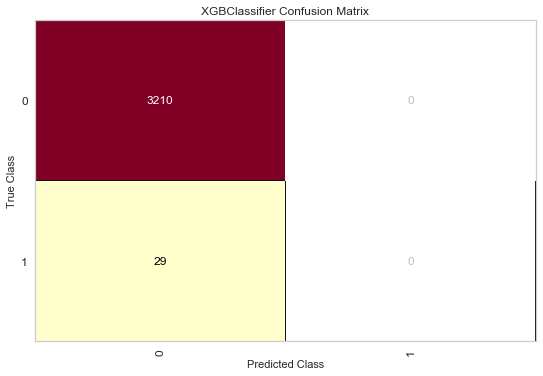

In [477]:
XGB_glip_cm = ConfusionMatrix(XGB_glip, classes = [0,1], label_encoder = {0:"No Insulin Rx", 1: "Insulin Rx"})
XGB_glip_cm.fit(X_train_glip, y_test_glip)
XGB_glip_cm.score(X_test_glip, y_test_glip)
XGB_glip_cm.show()

It looks like KNN with n_neighbors = 1 is our only model that has an F1 score higher than 0. Let's try using GridSearchCV to tune this and see if we can increase that F1 score. 

In [478]:
KNN_params_dict = {'weights': ['uniform', 'distance'],
                  'leaf_size': [10, 30, 50],
                  'metric': ['minkowski', 'euclidean']}

In [479]:
grid_KNN_glip = GridSearchCV(glip_KNN_1, KNN_params_dict, scoring = 'accuracy', cv = None, n_jobs = 1)
grid_KNN_glip.fit(X_train_glip, y_train_glip)

best_parameters_glip = grid_KNN_glip.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters_glip.keys()):
    print('%s: %r' % (param_name, best_parameters_glip[param_name]))

training_preds_glip = grid_KNN_glip.predict(X_train_glip)
test_preds_glip = grid_KNN_glip.predict(X_test_glip)
training_accuracy_glip = accuracy_score(y_train_glip, training_preds_glip)
test_accuracy_glip = accuracy_score(y_test_glip, test_preds_glip)

print("Training Accuracy: ", training_accuracy_glip)
print("Test Accuracy: ", test_accuracy_glip)

grid_KNN_glip_f1 = f1_score(y_test_glip, grid_KNN_glip.predict(X_test_glip))
print("F1 Score: ", grid_KNN_glip_f1)

C:\Users\kayce_000\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
leaf_size: 10
metric: 'minkowski'
weights: 'uniform'
Training Accuracy:  0.9993915424399148
Test Accuracy:  0.9836369249768447
F1 Score:  0.03636363636363637


Tuning the model yielded no improvement in performance, therefore we have the best possible model for predicting Glipizide prescriptions. 

Let's see what the top scoring features were.

In [481]:
glip_importances = glip_KNN_1.feature_importances_.round(2)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

Further analysis- looking into feature importance as it relates to Glipizide prescriptions. 

## Ideas for Future Work:
1. Try balancing data using SMOTE. We ran into a lot of problems here because of the unbalanced data. 
2. Look into ways of determining the feature importances of our KNN Glipizide model. It may be useful from a healthcare perspective to see why the model predicted the way it did. 
3. There are other ways to go about this same question - the dataset included diagnosis codes and blood insulin levels. There could be further information gleaned from looking at more than just prescriptions. 